### Potrzebne importy, wstępna konfiguracja

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from collections import Counter

from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [2]:
device = torch.device('cuda') # torch.device('cpu')
device

device(type='cuda')

In [3]:
rng = np.random.default_rng(73512)

### Przygotowanie danych (wraz z paddingiem)

In [7]:
train_data = pd.read_pickle('train.pkl')
test_data = pd.read_pickle('test_no_target.pkl')

In [8]:
all_elements = []
for i in train_data:
    for j in i[0]:
        all_elements.append(j)
elements_count = Counter(all_elements)
print(elements_count)
# df.plot(kind="bar")

Counter({12.0: 113916, 92.0: 63517, 47.0: 44650, 0.0: 43486, 44.0: 35785, 28.0: 33661, 159.0: 29503, 124.0: 29464, 13.0: 29334, 78.0: 26965, 45.0: 21287, 60.0: 21007, 112.0: 20988, 8.0: 19276, 88.0: 19203, 15.0: 18982, 79.0: 17975, 156.0: 17884, 5.0: 17278, 76.0: 17187, 125.0: 16829, 77.0: 16378, 33.0: 14950, 80.0: 14936, 172.0: 14740, 190.0: 14488, 145.0: 13366, -1.0: 13273, 127.0: 12150, 144.0: 11763, 30.0: 11753, 119.0: 11441, 73.0: 11298, 20.0: 11137, 180.0: 11127, 158.0: 11085, 93.0: 10393, 41.0: 10239, 32.0: 9622, 64.0: 9319, 157.0: 9297, 140.0: 8950, 68.0: 8548, 100.0: 8490, 185.0: 7563, 36.0: 7527, 111.0: 7374, 121.0: 7301, 14.0: 7208, 148.0: 7092, 2.0: 6957, 1.0: 6890, 132.0: 6799, 7.0: 6554, 46.0: 6418, 40.0: 6279, 120.0: 6215, 37.0: 6029, 95.0: 5960, 114.0: 5853, 65.0: 5732, 117.0: 5507, 67.0: 5502, 34.0: 5373, 160.0: 4825, 31.0: 4799, 146.0: 4752, 71.0: 4664, 152.0: 4614, 126.0: 4598, 29.0: 4461, 141.0: 4436, 110.0: 4390, 69.0: 4297, 82.0: 4253, 66.0: 4190, 175.0: 4154, 108

In [9]:
print(f"Minimalna wartość wśród danych: {min(all_elements)}")
print(f"Maksymalna wartość wśród danych: {max(all_elements)}")

Minimalna wartość wśród danych: -1.0
Maksymalna wartość wśród danych: 191.0


In [10]:
class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(torch.Tensor(x).float(), torch.tensor(y).long()) for x, y in zip(in_data, target)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

    def __print__(self):
        print(self.data)

In [11]:
data = [i[0] for i in train_data]
classes = [i[1] for i in train_data]

In [12]:
len([i for i in classes if i == 0])

1630

In [13]:
train_indices = rng.random(len(data)) > 0.3
train_indices

array([ True,  True,  True, ...,  True,  True,  True])

In [14]:
classes_train = [ x for i, x in enumerate(classes) if train_indices[i]]
classes_valid = [ x for i, x in enumerate(classes) if not train_indices[i]]
data_train = [ x for i, x in enumerate(data) if train_indices[i]]
data_valid = [ x for i, x in enumerate(data) if not train_indices[i]]

In [15]:
train_set = VariableLenDataset(data_train,
                               classes_train)
valid_set = VariableLenDataset(data_valid,
                               classes_valid)
# train_set.__print__()
train_set.__getitem__(1)

(tensor([ -1.,  -1., 144.,  ...,  32.,  -1.,  -1.]), tensor(0))

In [16]:
pad = -2

def pad_collate(batch, pad_value=pad):

    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy_tensor = torch.stack(yy)

    return xx_pad, yy_tensor, x_lens

In [17]:
def compute_classes_weights(classes):
    classes_count = []
    classes_count.append(len([i for i in classes if i == 0]))
    classes_count.append(len([i for i in classes if i == 1]))
    classes_count.append(len([i for i in classes if i == 2]))
    classes_count.append(len([i for i in classes if i == 3]))
    classes_count.append(len([i for i in classes if i == 4]))
    classes_count = torch.tensor(classes_count)
    weights = 1. / classes_count.float()
    sample_weights = torch.tensor([weights[t] for t in classes])
    return sample_weights

In [25]:
train_loader = DataLoader(train_set, batch_size=64, collate_fn=pad_collate, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=64, collate_fn=pad_collate, shuffle=True)

### Model (wstępny)

In [20]:
class LSTM_Seq_Regressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, bidirectional=False, drop_out=0):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional =1
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, 
                            proj_size = out_size, bidirectional = bidirectional, dropout=drop_out)
        self.fc2 = nn.Linear(hidden_size, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers*self.bidirectional, batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden):
        all_outputs, hidden = self.lstm(x, hidden)
        return all_outputs, hidden



In [28]:
def eval(loader, net):

    correct_pred = 0
    total_pred = 0
    net.eval()
    loss_fun = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, targets, x_len in loader:
            # images = images.to(device)
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)

            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)

            x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
            preds_packed, _ = model(x_packed, (hidden, state))
            preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)

            preds = preds.squeeze(2)
            last_outputs = []
            for i, length in enumerate(pred_len):
                last_outputs.append(preds[i, length -1 , :])
            last_outputs = torch.stack(last_outputs)
            loss = loss_fun(last_outputs, targets)

            _, predictions = torch.max(last_outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(targets, predictions):
                if label == prediction:
                    correct_pred += 1
                total_pred += 1
    return correct_pred/total_pred, loss


In [29]:
model = LSTM_Seq_Regressor(1, 100, 1, 5).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 100, proj_size=5)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)

In [30]:
def train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.001, epoch_number=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    loss_fun = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(epoch_number):
        for x, targets, x_len in train_loader:
            # print(f"Trening: {x} oraz {targets}")
            model.train()
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)
    
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
    
            x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
            preds_packed, _ = model(x_packed, (hidden, state))
            preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)
    
            preds = preds.squeeze(2)
            last_outputs = []
            for i, length in enumerate(pred_len):
                last_outputs.append(preds[i, length -1 , :])
            last_outputs = torch.stack(last_outputs)
            optimizer.zero_grad()
            # mask = targets != pad
            # print(mask)
            loss = loss_fun(last_outputs, targets)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            acc_valid, loss_valid = eval(valid_loader, model)
            acc_train, loss_train = eval(train_loader, model)
            train_loss.append(loss_train)
            valid_loss.append(loss_valid)
            train_acc.append(acc_train)
            valid_acc.append(acc_valid)
            print(f"Epoch: {epoch}, loss train: {loss_train.item():.3}, loss valid: {loss_valid}")
            print(f'Accuracy train: {acc_train}')
            print(f'Accuracy valid: {acc_valid}')

In [31]:
def plot_metrics(train_loss, valid_loss, train_acc, valid_acc):
    iters_losses = [i for i in range(len(train_loss))]
    iters_acc = [i for i in range(len(train_acc))]
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters_losses, train_loss, label="Train")
    plt.plot(iters_losses, valid_loss, label="Valid")
    plt.legend(loc='best')
    plt.ylabel("Loss")
    
    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, valid_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    
    plt.show()
    
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))


## Dla zestackowanego modułu LSTM

In [33]:
model = LSTM_Seq_Regressor(1, 10, 2, 5, bidirectional=True).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.001)

Epoch: 0, loss train: 2.2, loss valid: 2.160252332687378
Accuracy train: 0.5399802566633761
Accuracy valid: 0.5410733844468785
Epoch: 10, loss train: 1.16, loss valid: 1.3635046482086182
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5575027382256298
Epoch: 20, loss train: 1.22, loss valid: 1.20574152469635
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5575027382256298
Epoch: 30, loss train: 1.33, loss valid: 1.2373971939086914
Accuracy train: 0.5839091806515301
Accuracy valid: 0.592552026286966
Epoch: 40, loss train: 1.27, loss valid: 1.1390950679779053
Accuracy train: 0.6016781836130306
Accuracy valid: 0.6002190580503833
Epoch: 50, loss train: 1.12, loss valid: 0.996810257434845
Accuracy train: 0.6066140177690029
Accuracy valid: 0.6056955093099672
Epoch: 60, loss train: 0.929, loss valid: 0.9402056336402893
Accuracy train: 0.6100691016781836
Accuracy valid: 0.6024096385542169


KeyboardInterrupt: 

# Ustalanie odpowiedniego samplingu

### Sampling za pomocą WeighteRandomSampler - wielkość zbioru nie zmieniona

Wielkość zbiory nie jest zmieniona, każda próbka ma przypisane prawdopodobieństwo, żeby próbki każdej klasy były wybieranie odpowiednio często.

In [124]:
samples_weights_train = compute_classes_weights(classes_train)
samples_weights_valid = compute_classes_weights(classes_valid)

In [160]:
sampler_train = torch.utils.data.WeightedRandomSampler(samples_weights_train, len(samples_weights_train), replacement=True)
sampler_valid = torch.utils.data.WeightedRandomSampler(samples_weights_valid, len(samples_weights_valid), replacement=True)
train_loader = DataLoader(train_set, batch_size=64, collate_fn=pad_collate, sampler=sampler_train)
valid_loader = DataLoader(valid_set, batch_size=64, collate_fn=pad_collate, shuffle=True)

Hidden size = 100

In [166]:
model = LSTM_Seq_Regressor(1, 100, 1, 5).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 100, proj_size=5)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)

In [167]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [168]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc)

Epoch: 0, loss train: 1.55, loss valid: 1.6545504331588745
Accuracy train: 0.32576505429417574
Accuracy valid: 0.24644030668127054
Epoch: 10, loss train: 1.23, loss valid: 1.2522075176239014
Accuracy train: 0.5029615004935835
Accuracy valid: 0.4370208105147864
Epoch: 20, loss train: 0.927, loss valid: 1.230544090270996
Accuracy train: 0.577492596248766
Accuracy valid: 0.5859802847754655
Epoch: 30, loss train: 0.894, loss valid: 0.8028404116630554
Accuracy train: 0.6268509378084897
Accuracy valid: 0.628696604600219
Epoch: 40, loss train: 0.918, loss valid: 1.0791187286376953
Accuracy train: 0.6327739387956565
Accuracy valid: 0.6440306681270537
Epoch: 50, loss train: 0.958, loss valid: 0.7647656202316284
Accuracy train: 0.7033563672260612
Accuracy valid: 0.628696604600219
Epoch: 60, loss train: 0.671, loss valid: 0.9057462811470032
Accuracy train: 0.7181638696939783
Accuracy valid: 0.6308871851040526
Epoch: 70, loss train: 0.639, loss valid: 0.5782299637794495
Accuracy train: 0.754195459

In [169]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]

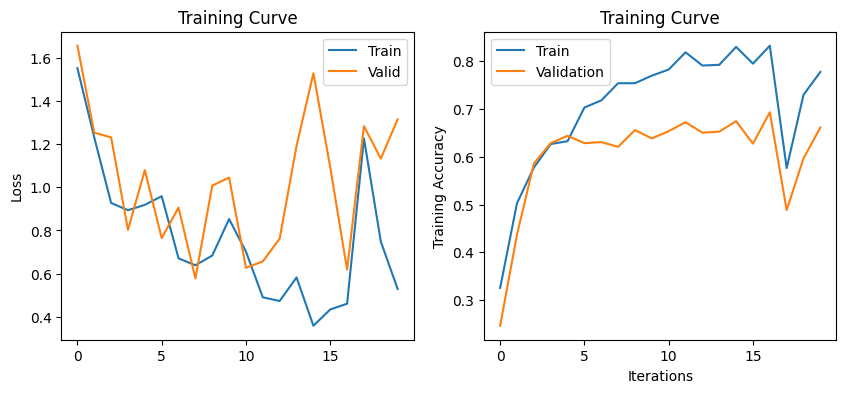

Final Training Accuracy: 0.7778874629812438
Final Validation Accuracy: 0.6615553121577218


In [170]:
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

### Z dodanym drop outem

In [171]:
model = LSTM_Seq_Regressor(1, 100, 1, 5, drop_out=0.3).to(device)
model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM_Seq_Regressor(
  (lstm): LSTM(1, 100, proj_size=5, dropout=0.3)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)

In [172]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [173]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc)

Epoch: 0, loss train: 1.58, loss valid: 1.5740151405334473
Accuracy train: 0.2917077986179664
Accuracy valid: 0.15005476451259583
Epoch: 10, loss train: 1.26, loss valid: 1.318078637123108
Accuracy train: 0.4817374136229023
Accuracy valid: 0.48083242059145676
Epoch: 40, loss train: 0.889, loss valid: 0.9382912516593933
Accuracy train: 0.6554787759131293
Accuracy valid: 0.588170865279299
Epoch: 50, loss train: 0.902, loss valid: 0.9624391198158264
Accuracy train: 0.6539980256663376
Accuracy valid: 0.6254107338444688
Epoch: 60, loss train: 0.787, loss valid: 0.6422419548034668
Accuracy train: 0.6846001974333662
Accuracy valid: 0.619934282584885
Epoch: 70, loss train: 0.641, loss valid: 1.3497934341430664
Accuracy train: 0.7507403751233959
Accuracy valid: 0.624315443592552
Epoch: 80, loss train: 0.746, loss valid: 0.9073887467384338
Accuracy train: 0.7576505429417572
Accuracy valid: 0.6538882803943045
Epoch: 90, loss train: 0.761, loss valid: 1.3995146751403809
Accuracy train: 0.667818361

In [174]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]

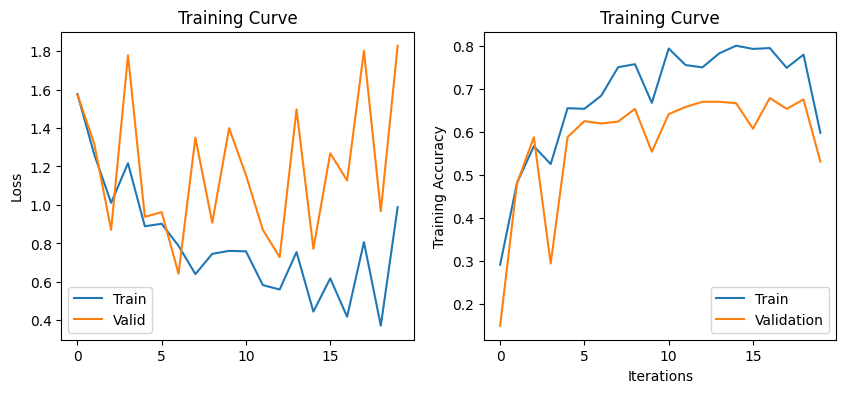

Final Training Accuracy: 0.5982230997038499
Final Validation Accuracy: 0.5312157721796276


In [175]:
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

### Dla undersamplingu

In [183]:
sampler_train = torch.utils.data.WeightedRandomSampler(samples_weights_train, len(samples_weights_train), replacement=False)
sampler_valid = torch.utils.data.WeightedRandomSampler(samples_weights_valid, len(samples_weights_valid), replacement=False)
train_loader = DataLoader(train_set, batch_size=64, collate_fn=pad_collate, sampler=sampler_train)
valid_loader = DataLoader(valid_set, batch_size=64, collate_fn=pad_collate, shuffle=True)

In [184]:
model = LSTM_Seq_Regressor(1, 100, 1, 5, drop_out=0.3).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 100, proj_size=5, dropout=0.3)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)

In [189]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [ ]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc)

Epoch: 0, loss train: 0.254, loss valid: 0.9841160774230957
Accuracy train: 0.5888450148075025
Accuracy valid: 0.5991237677984665
Epoch: 10, loss train: 0.271, loss valid: 1.1886627674102783
Accuracy train: 0.6436327739387957
Accuracy valid: 0.6396495071193866
Epoch: 20, loss train: 0.33, loss valid: 1.1868410110473633
Accuracy train: 0.6520236920039487
Accuracy valid: 0.6473165388828039
Epoch: 30, loss train: 0.231, loss valid: 1.101635217666626
Accuracy train: 0.6436327739387957
Accuracy valid: 0.6429353778751369
Epoch: 40, loss train: 0.236, loss valid: 1.6211743354797363
Accuracy train: 0.6599210266535045
Accuracy valid: 0.651697699890471
Epoch: 50, loss train: 0.308, loss valid: 0.9665952324867249
Accuracy train: 0.6658440276406713
Accuracy valid: 0.6549835706462213


In [ ]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]

In [ ]:
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

### Dla modelu "bidirectional"

In [ ]:
model = LSTM_Seq_Regressor(1, 100, 1, 5, bidirectional=True, drop_out=0.01).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.001)

In [106]:
model = LSTM_Seq_Regressor(1, 100, 1, 5).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.0001)

Epoch: 0, loss train: 1.61, loss valid: 1.5999842882156372
Accuracy train: 0.09081934846989141
Accuracy valid: 0.09419496166484119
Epoch: 1, loss train: 1.56, loss valid: 1.5440617799758911
Accuracy train: 0.1895360315893386
Accuracy valid: 0.22343921139101863
Epoch: 2, loss train: 1.53, loss valid: 1.478910207748413
Accuracy train: 0.5212240868706811
Accuracy valid: 0.5224534501642936
Epoch: 3, loss train: 1.48, loss valid: 1.4822072982788086
Accuracy train: 0.5429417571569596
Accuracy valid: 0.547645125958379
Epoch: 4, loss train: 1.46, loss valid: 1.3822956085205078
Accuracy train: 0.5468904244817374
Accuracy valid: 0.5531215772179627
Epoch: 5, loss train: 1.44, loss valid: 1.48439359664917
Accuracy train: 0.5463968410661402
Accuracy valid: 0.5553121577217963
Epoch: 6, loss train: 1.45, loss valid: 1.4844703674316406
Accuracy train: 0.5493583415597236
Accuracy valid: 0.5553121577217963
Epoch: 7, loss train: 1.31, loss valid: 1.4276914596557617
Accuracy train: 0.5513326752221125
Accu

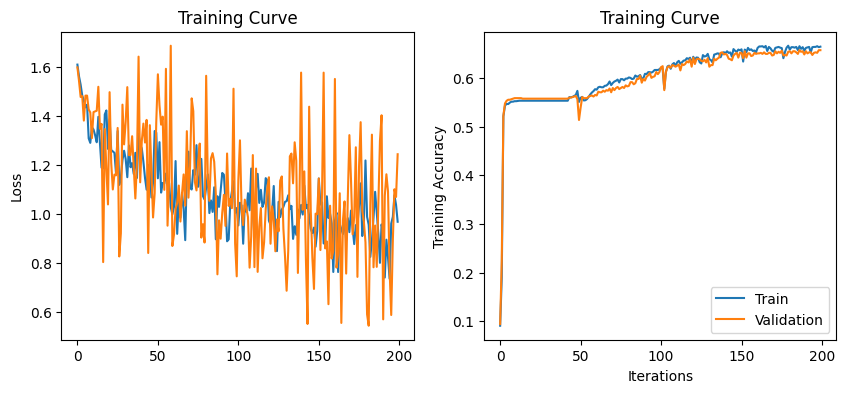

Final Training Accuracy: 0.6643632773938796
Final Validation Accuracy: 0.6571741511500547


In [108]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

In [115]:
model = LSTM_Seq_Regressor(1, 100, 1, 5, bidirectional=True).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.001)

Epoch: 0, loss train: 1.79, loss valid: 1.7044988870620728
Accuracy train: 0.5513326752221125
Accuracy valid: 0.556407447973713
Epoch: 1, loss train: 1.43, loss valid: 1.7653684616088867
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5585980284775466
Epoch: 2, loss train: 1.26, loss valid: 1.3409425020217896
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5575027382256298
Epoch: 3, loss train: 1.29, loss valid: 1.0173066854476929
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5575027382256298
Epoch: 4, loss train: 1.21, loss valid: 1.0177935361862183
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5575027382256298
Epoch: 5, loss train: 1.28, loss valid: 1.1148194074630737
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5575027382256298
Epoch: 6, loss train: 1.17, loss valid: 1.4754726886749268
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5575027382256298
Epoch: 7, loss train: 1.13, loss valid: 1.090926170349121
Accuracy train: 0.5656465942744324
Accur

KeyboardInterrupt: 

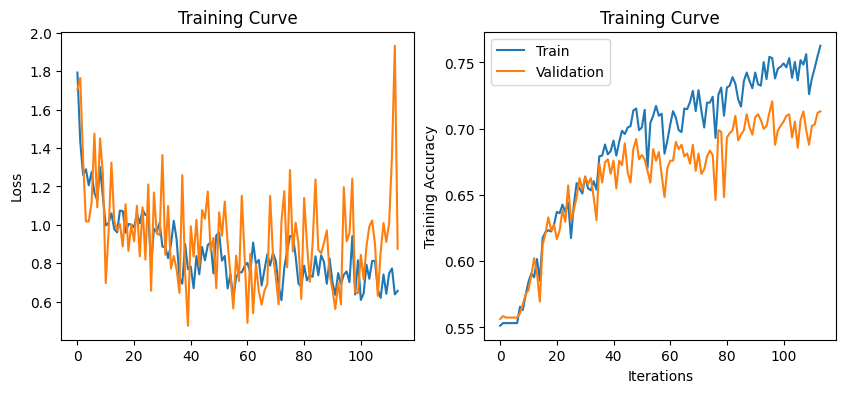

Final Training Accuracy: 0.7625863770977295
Final Validation Accuracy: 0.7130339539978094


In [116]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

### Model (do poprawy)

In [ ]:
num_of_columns_without_classes = 50

class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, bidirectional = False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional=bidirectional, dropout=0.4)
        self.fc = nn.Linear(hidden_size*num_of_columns_without_classes*self.bidirectional, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        out = torch.flatten(all_outputs,1)
        x = self.fc(out)
        return x, hidden

model = LSTMRegressor(1,5,2,1).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 5, num_layers=2, dropout=0.4)
  (fc): Linear(in_features=250, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.CrossEntropyLoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        print(f"AAA: {type(targets)}")
        x = x.to(device).unsqueeze(2)
#         x = x.unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, (hidden,state))
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

ValueError: too many values to unpack (expected 2)

In [ ]:
# with torch.no_grad():
#     hidden, state = model.init_hidden(len(test_data))
#     hidden, state = hidden.to(device), state.to(device)
#     preds,_ =  model(test_data.to(device).unsqueeze(2), (hidden,state))
# print(f"Accuracy: {(torch.argmax(preds,1).cpu()==test_targets).sum().item()/len(test_targets):.3}")

## Trenowanie od nowa

## Trenowanie modelu dla oversamplingu

In [43]:
samples_weights_train = compute_classes_weights(classes_train)
samples_weights_valid = compute_classes_weights(classes_valid)

In [44]:
sampler_train = torch.utils.data.WeightedRandomSampler(samples_weights_train, len(samples_weights_train), replacement=True)
sampler_valid = torch.utils.data.WeightedRandomSampler(samples_weights_valid, len(samples_weights_valid), replacement=True)
train_loader = DataLoader(train_set, batch_size=64, collate_fn=pad_collate, sampler=sampler_train)
valid_loader = DataLoader(valid_set, batch_size=64, collate_fn=pad_collate, sampler=sampler_valid)

In [45]:
model = LSTM_Seq_Regressor(1, 40, 2, 5, bidirectional=False, drop_out=0.3).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [48]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.002)

Epoch: 0, loss train: 0.894, loss valid: 1.2151155471801758
Accuracy train: 0.6554787759131293
Accuracy valid: 0.5629791894852135
Epoch: 10, loss train: 0.887, loss valid: 1.3185776472091675
Accuracy train: 0.6791707798617966
Accuracy valid: 0.5706462212486308
Epoch: 20, loss train: 0.92, loss valid: 0.8192285299301147
Accuracy train: 0.6253701875616979
Accuracy valid: 0.5334063526834611
Epoch: 30, loss train: 0.823, loss valid: 0.8957592248916626
Accuracy train: 0.6510365251727542
Accuracy valid: 0.5772179627601315
Epoch: 40, loss train: 1.01, loss valid: 1.0376639366149902
Accuracy train: 0.6515301085883515
Accuracy valid: 0.5662650602409639
Epoch: 50, loss train: 1.16, loss valid: 1.0977438688278198
Accuracy train: 0.6411648568608095
Accuracy valid: 0.579408543263965
Epoch: 60, loss train: 0.716, loss valid: 0.9331713318824768
Accuracy train: 0.6732477788746298
Accuracy valid: 0.588170865279299
Epoch: 70, loss train: 0.944, loss valid: 1.2523932456970215
Accuracy train: 0.6623889437

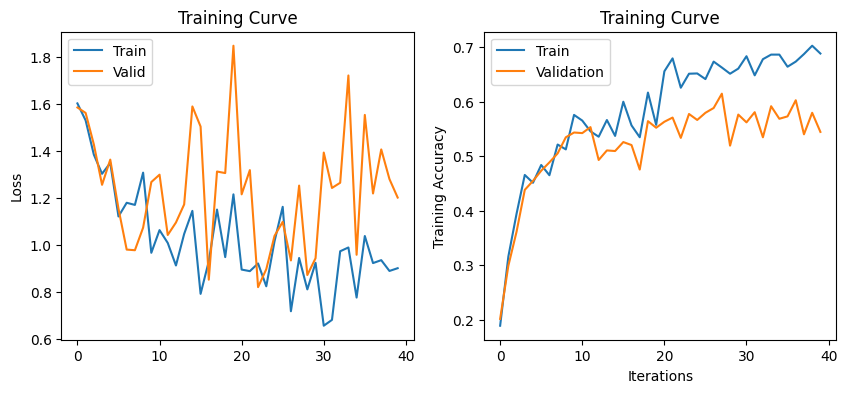

Final Training Accuracy: 0.6880552813425469
Final Validation Accuracy: 0.5443592552026287


In [49]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)